133
chessboard not found in calib_large_circle/calib_15.png
chessboard not found in calib_large_circle/calib_29.png
chessboard found in calib_large_circle/calib_1.png


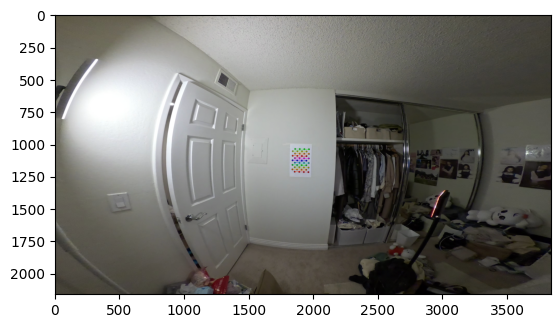

chessboard not found in calib_large_circle/calib_105.png
chessboard not found in calib_large_circle/calib_111.png
chessboard not found in calib_large_circle/calib_110.png
chessboard not found in calib_large_circle/calib_104.png
chessboard found in calib_large_circle/calib_0.png


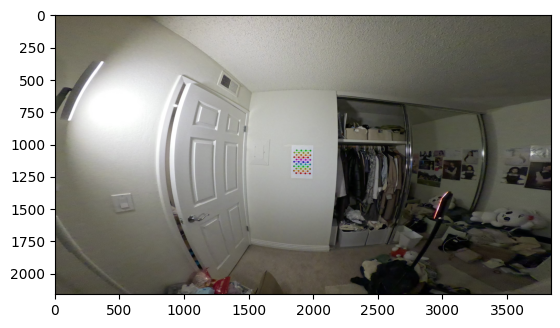

chessboard not found in calib_large_circle/calib_28.png
chessboard not found in calib_large_circle/calib_14.png
chessboard not found in calib_large_circle/calib_16.png
chessboard found in calib_large_circle/calib_2.png


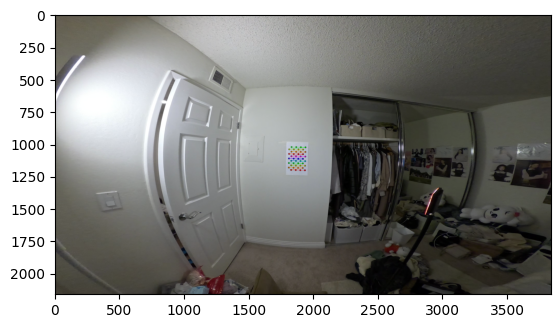

chessboard not found in calib_large_circle/calib_112.png
chessboard not found in calib_large_circle/calib_106.png
chessboard not found in calib_large_circle/calib_107.png
chessboard not found in calib_large_circle/calib_113.png
chessboard found in calib_large_circle/calib_3.png


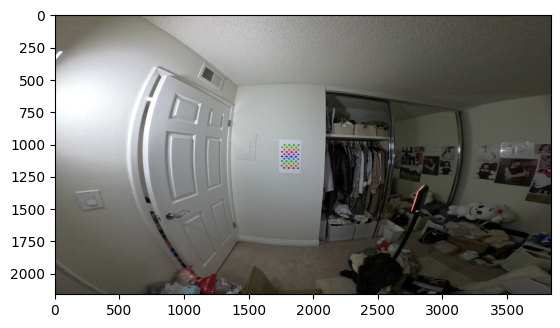

chessboard not found in calib_large_circle/calib_17.png
chessboard not found in calib_large_circle/calib_13.png
chessboard found in calib_large_circle/calib_7.png


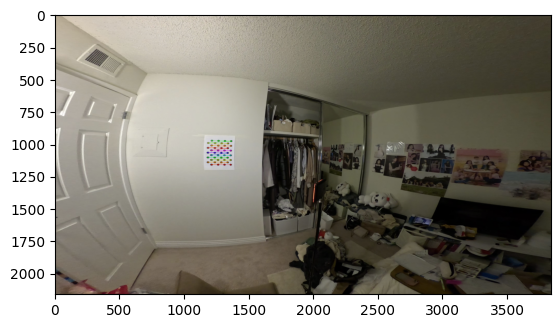

chessboard found in calib_large_circle/calib_117.png


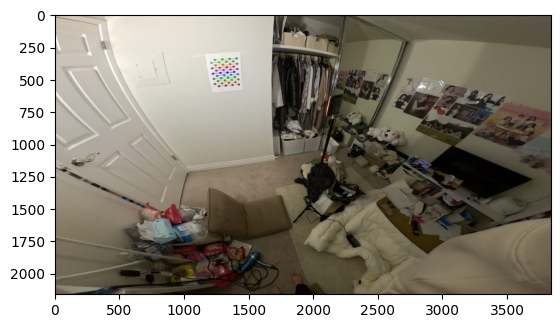

chessboard not found in calib_large_circle/calib_103.png
chessboard not found in calib_large_circle/calib_102.png
chessboard found in calib_large_circle/calib_116.png


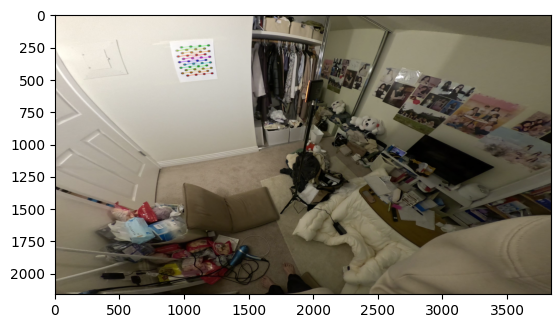

chessboard found in calib_large_circle/calib_6.png


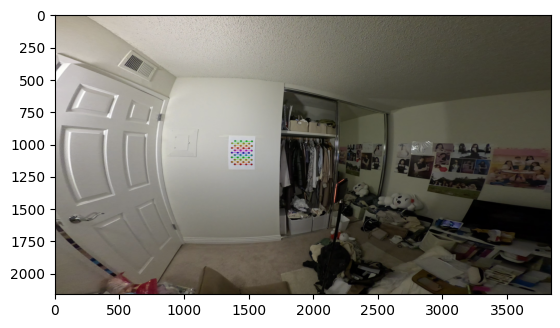

chessboard not found in calib_large_circle/calib_12.png
chessboard found in calib_large_circle/calib_38.png


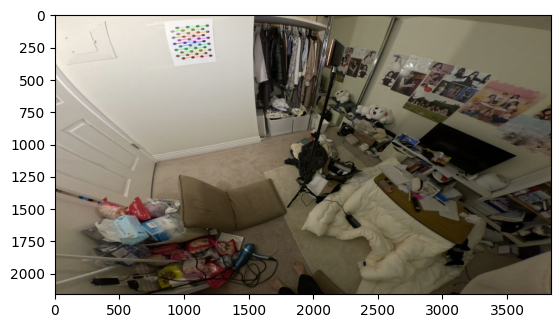

chessboard not found in calib_large_circle/calib_10.png
chessboard found in calib_large_circle/calib_4.png


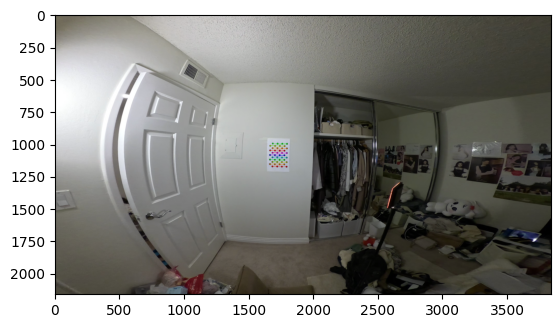

chessboard not found in calib_large_circle/calib_100.png
chessboard not found in calib_large_circle/calib_114.png
chessboard found in calib_large_circle/calib_128.png
chessboard found in calib_large_circle/calib_129.png
chessboard not found in calib_large_circle/calib_115.png
chessboard not found in calib_large_circle/calib_101.png
chessboard found in calib_large_circle/calib_5.png
chessboard not found in calib_large_circle/calib_11.png
chessboard found in calib_large_circle/calib_39.png
chessboard not found in calib_large_circle/calib_62.png
chessboard not found in calib_large_circle/calib_76.png
chessboard found in calib_large_circle/calib_89.png
chessboard found in calib_large_circle/calib_88.png
chessboard not found in calib_large_circle/calib_77.png
chessboard not found in calib_large_circle/calib_63.png
chessboard not found in calib_large_circle/calib_75.png
chessboard not found in calib_large_circle/calib_61.png
chessboard not found in calib_large_circle/calib_49.png
chessboard 

In [4]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

CHECKERBOARD = (4,11)

subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW

objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('calib_large_circle/*.png')
count = 0
print(len(images))

for fname in images:
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findCirclesGrid(gray, CHECKERBOARD, flags=cv2.CALIB_CB_ASYMMETRIC_GRID)
    if ret:
        print(f"chessboard found in {fname}")
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners, ret)
        fname_without_ext = os.path.splitext(os.path.basename(fname))[0]
        cv2.imwrite("corner_original/" + fname_without_ext + ".png",img)
        if count < 10:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.show()
        count += 1
    else:
        print(f"chessboard not found in {fname}")

if len(objpoints) > 0 and len(imgpoints) > 0:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print("Camera matrix:")
    print(mtx)
    print("Distort:")
    print(dist)
    print("Rotate vector:")
    print(rvecs)
    print("Translation vector:")
    print(tvecs)

In [5]:
def undistort_remap(img_path, num):
    img = cv2.imread(img_path)
    h,w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None, newcameramtx, (w,h),5)
    dst = cv2.remap(img,mapx,mapy,cv2.INTER_LANCZOS4)

    #crop
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    fname_without_ext = os.path.splitext(os.path.basename(img_path))[0]
    cv2.imwrite("undistorted_original_remap/" + fname_without_ext + ".png",dst)
    if num < 10:
        print(fname_without_ext + " before")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        print(fname_without_ext + " after")
        plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        plt.show()

In [6]:
def undistort_undisort(img_path, num):
    img = cv2.imread(img_path)
    h,w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
    dst = cv2.remap(img,mapx,mapy,cv2.INTER_LANCZOS4)

    #crop
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    fname_without_ext = os.path.splitext(os.path.basename(img_path))[0]
    cv2.imwrite("undistorted_original_undistort/" + fname_without_ext + ".png",dst)
    if num < 10:
        print(fname_without_ext + " before")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        print(fname_without_ext + " after")
        plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        plt.show()

calib_15 before


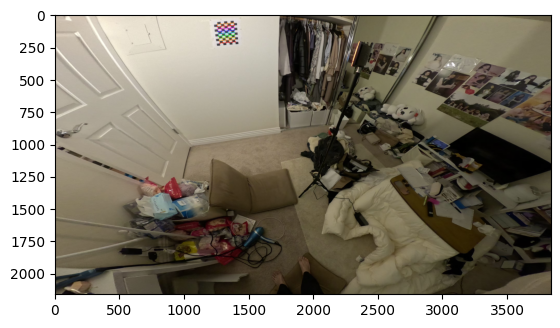

calib_15 after


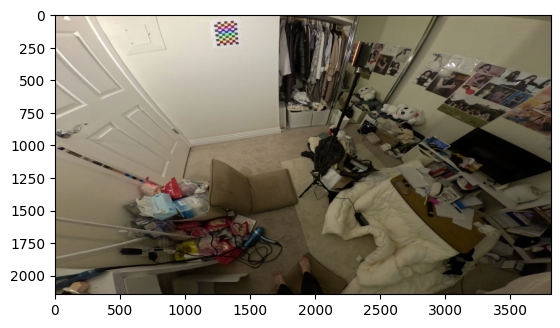

calib_29 before


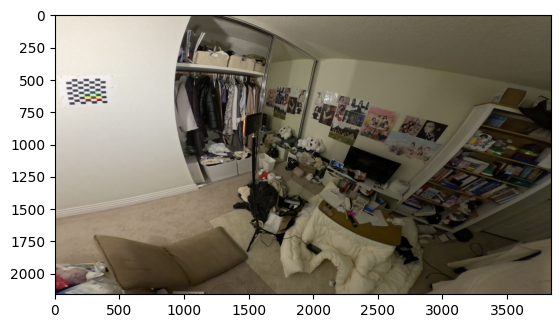

calib_29 after


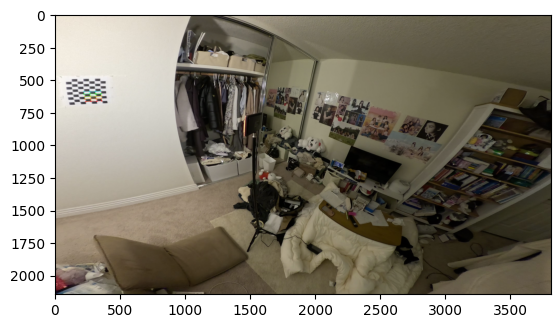

calib_1 before


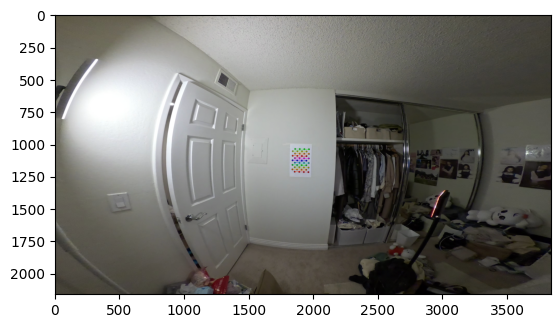

calib_1 after


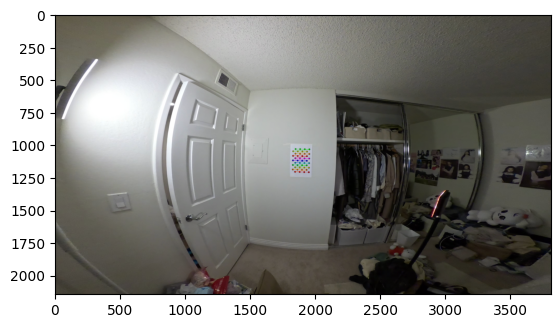

calib_105 before


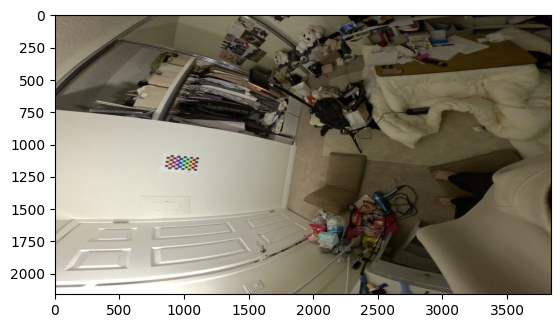

calib_105 after


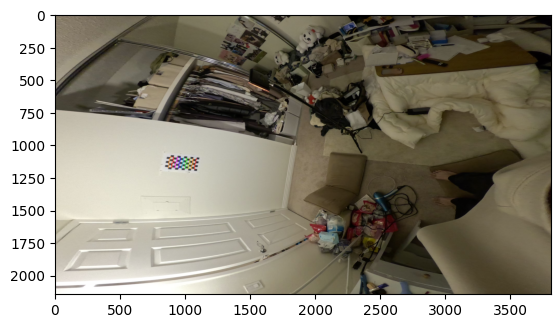

calib_111 before


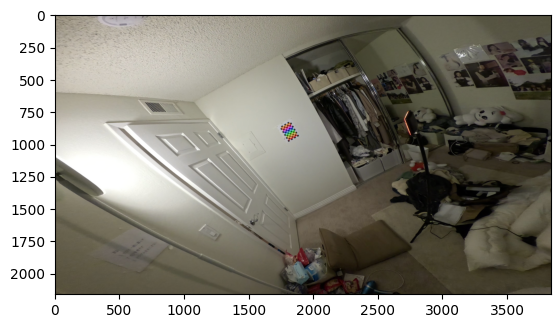

calib_111 after


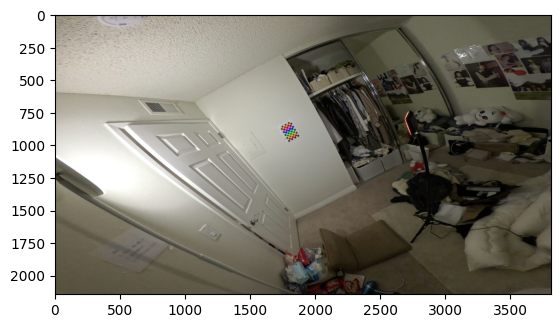

calib_110 before


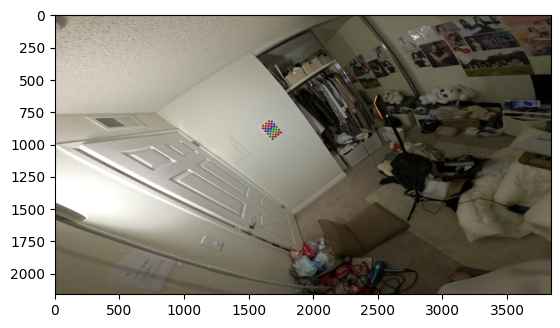

calib_110 after


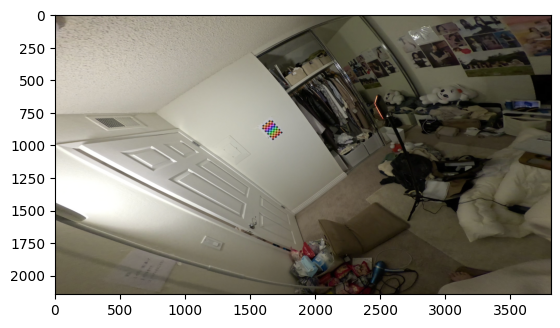

calib_104 before


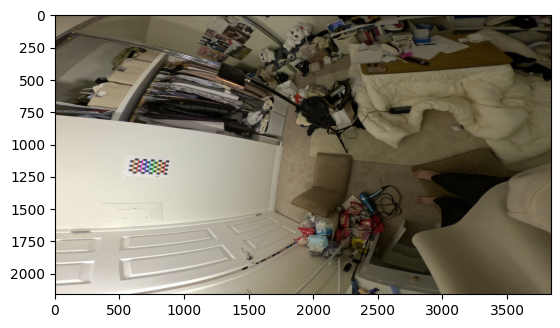

calib_104 after


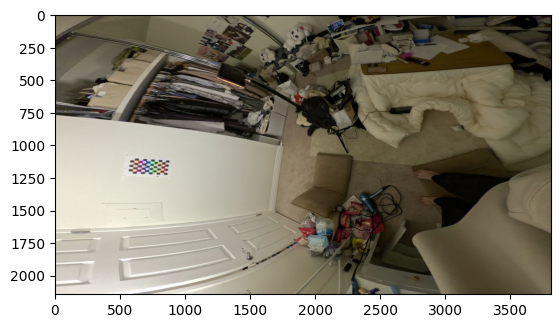

calib_0 before


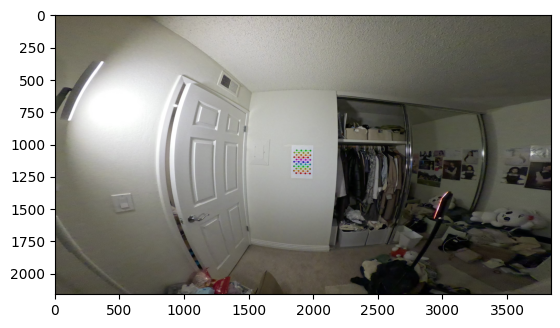

calib_0 after


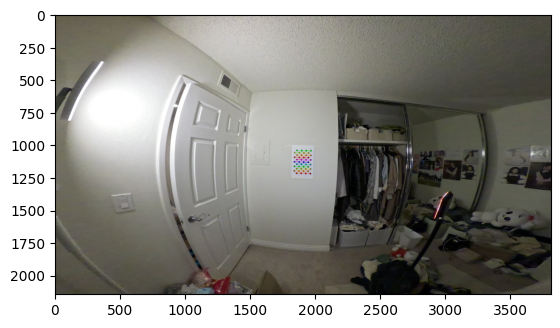

calib_28 before


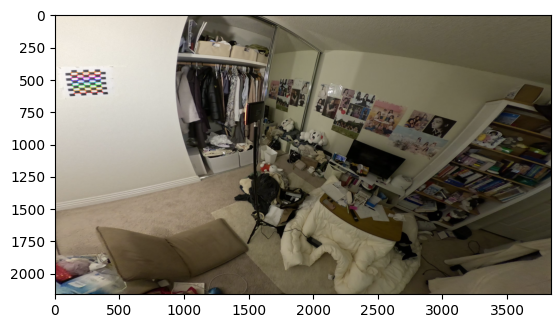

calib_28 after


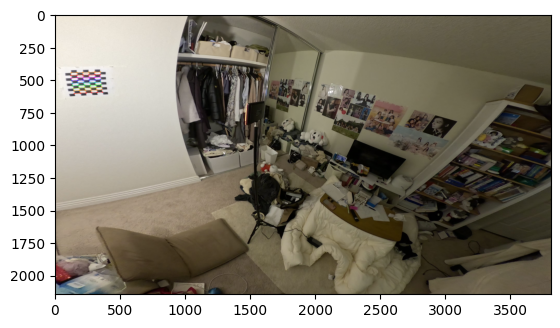

calib_14 before


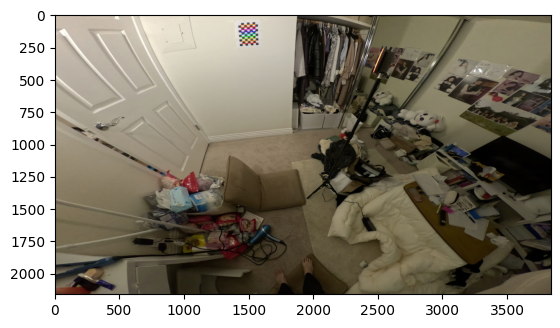

calib_14 after


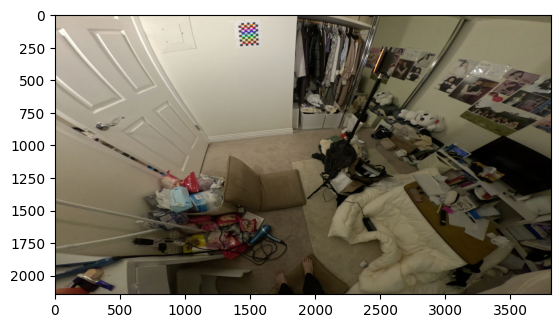

In [7]:
corner_images = glob.glob('corner_original/*.png')
for ind, fname in enumerate(corner_images):
    undistort_remap(fname, ind)

In [10]:
def print_reprojection_error():
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        #print(imgpoints2.shape)
        #print(imgpoints[i].shape)
        #imgpoints2 = imgpoints2.reshape(54, 1, 2)
        #print(imgpoints2.shape)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    print("reprojection error: {}".format(mean_error/len(objpoints)))

In [11]:
print_reprojection_error()

reprojection error: 1.7424687468174906
